In [79]:
%pylab inline

import matplotlib.pyplot as plt
import os
import pandas as pd
import scipy.stats
import matplotlib.patches as patches

# Load PCA results
pca = pd.read_csv("/storage/s1saini/ssc-pca/pca_10.eigenvec", sep=" ",
                 names=["sample","sample2"]+["pc%s"%i for i in range(1,11)])

# Load 1kg population labels
onekg = pd.read_csv("../other_data/1000GenomesPopulations.csv")

# Load pedigree info
ped = pd.read_csv("../../metadata/ssc_family_ids.txt", sep="\t", names=["id","sample"])
ped["family"] = ped["id"].apply(lambda x: x.split(".")[0])
ped["rel"] = ped["id"].apply(lambda x: x.split(".")[1])

# Merge final data
data = pd.merge(pca, onekg, on="sample", how="left")
data = pd.merge(data, ped[["family","rel","sample"]], on="sample", how="left")

Populating the interactive namespace from numpy and matplotlib


/usr/lib64/python3.4/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


EAS	36
AFR	48
SAS	114
EUR	1504


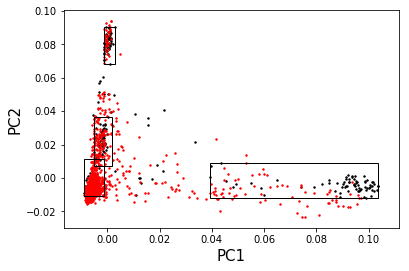

In [80]:
# Plot PCA to get boundaries
fig = plt.figure()
ax = fig.add_subplot(111)

refdata = data[(data["Population"].apply(lambda x: str(x) != "nan"))]
ax.scatter(refdata["pc1"], refdata["pc2"], color="black", s=2);

ssc = data[(data["Population"].apply(lambda x: str(x) == "nan"))]
ax.scatter(ssc["pc1"], ssc["pc2"], color="red", s=2);
ax.set_xlabel("PC1", size=15)
ax.set_ylabel("PC2", size=15);

# Get Europeans boundaries
#for popname in set(refdata["Superpop"]):
for popname in ["EAS","AFR","SAS","EUR"]:
    pop = refdata[refdata["Superpop"]==popname]
    max_pc1 = max(pop["pc1"])
    min_pc1 = min(pop["pc1"])
    max_pc2 = max(pop["pc2"])
    min_pc2 = min(pop["pc2"])
    ssc_pop = ssc[(ssc["pc1"]>=min_pc1) & (ssc["pc1"]<=max_pc1) &
                 (ssc["pc2"]>=min_pc2) & (ssc["pc2"]<=max_pc2)]
    ssc.ix[ssc["sample"].apply(lambda x: x in ssc_pop["sample"].values),"Superpop"] = popname
    print("\t".join([popname, str(ssc_pop.shape[0])]))
    ax.add_patch(
        patches.Rectangle(
        (min_pc1, min_pc2),
        max_pc1-min_pc1,
        max_pc2-min_pc2,
        fill=False
        ))

In [82]:
def concat(x):
    items = list(set([str(item) for item in x if str(item) != "nan"]))
    if len(items)==0 or len(items)> 1: return "Admixed"
    else: return ",".join(items)
ssc_family = ssc.groupby("family", as_index=False).agg({"Superpop": concat})
ssc_family.to_csv("../../metadata/ssc_family_populations.tab", sep="\t", index=False)